In [3]:
import torch
from torch import nn
from model import BiLSTM_FullOutput
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [4]:
train_data_path = "../../train_hourly.csv"
test_data_path = "../../test_hourly.csv"

In [5]:
input_hours = 90 * 24       # 输入序列长度（90天）
output_hours = 90 * 24

use_cols = [
    'Global_active_power','Global_reactive_power',
    'Global_intensity','Sub_metering_1',
    'Sub_metering_2','Sub_metering_3',
    'sub_metering_remainder'
]

def load_hourly(path):
    df = pd.read_csv(path, parse_dates=['DateTime'])
    df.sort_values('DateTime', inplace=True)
    df.reset_index(drop=True, inplace=True)

    # 计算 sub_metering_remainder
    df["sub_metering_remainder"] = (
        df["Global_active_power"] * 1000 / 60
        - df["Sub_metering_1"]
        - df["Sub_metering_2"]
        - df["Sub_metering_3"]
    ).clip(lower=0)

    df = df[['DateTime'] + use_cols].copy()
    df.ffill(inplace=True)
    df.bfill(inplace=True)
    return df

train_df = load_hourly(train_data_path)
test_df  = load_hourly(test_data_path) 


full_df = pd.concat([train_df, test_df], ignore_index=True)

# ========= 标准化 ========= #
# scaler = MinMaxScaler()
# scaled = scaler.fit_transform(full_df[use_cols])
# target = scaled[:, 0]  # 目标值：Global_active_power
scaled = full_df[use_cols].values  # 直接使用原始值
target = scaled[:, 0]


# ========= 滑动窗口构造函数 ========= #
def build_samples(data, target, input_len, output_len, step=1):
    X, y = [], []
    for i in range(input_len, len(data) - output_len + 1, step):
        X.append(data[i - input_len:i])
        y.append(target[i:i + output_len])
    return np.array(X), np.array(y)

# ========= 构建样本 ========= #
X_all, y_all = build_samples(scaled, target, input_hours, output_hours, step=1)


# ========= 拆分 train / test ========= #
split_index = len(train_df) - input_hours  # 同样逻辑保证 test 在真实 test 部分
X_train = X_all[:split_index]
y_train = y_all[:split_index]
X_test  = X_all[split_index:]
y_test  = y_all[split_index:]


print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test  shape: {X_test.shape}")
print(f"y_test  shape: {y_test.shape}")

X_train shape: (15751, 2160, 7)
y_train shape: (15751, 2160)
X_test  shape: (14519, 2160, 7)
y_test  shape: (14519, 2160)


In [6]:
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
import os

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
batch_size = 256

train_ds = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32)
)
val_size = int(len(train_ds) * 0.2)
train_size = len(train_ds) - val_size
train_subset, val_subset = random_split(train_ds, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)



In [5]:
os.makedirs("output/models/pred90", exist_ok=True)
os.makedirs("output/pics/loss/pred90", exist_ok=True)

# 保存所有 loss 用于计算平均曲线
all_train_losses = []
all_val_losses = []
mae_list = []
mse_list = []

for run in range(1, 6):
    print(f"\n=== Run {run} ===")
    SEED = 42 + run  # 每组不同 seed
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    model = BiLSTM_FullOutput(
        input_size=7,
        hidden_size=128,
        output_len=2160,
        num_layers=2,
        dropout=0.3
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

    train_losses, val_losses = [], []
    best_val = float('inf')
    best_model = None
    best_mae = None
    best_mse = None
    patience = 10
    no_improve = 0

    for epoch in range(1, 101):
        model.train()
        total_train_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * xb.size(0)
        avg_train = total_train_loss / len(train_subset)
        train_losses.append(avg_train)

        # 验证
        all_preds, all_gts = [], []
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                loss = criterion(pred, yb)
                total_val_loss += loss.item() * xb.size(0)
                all_preds.append(pred.cpu().numpy())
                all_gts.append(yb.cpu().numpy())


        all_preds = np.concatenate(all_preds, axis=0)
        all_gts = np.concatenate(all_gts, axis=0)

        avg_val = total_val_loss / len(val_subset)
        val_losses.append(avg_val)

        val_mae = mean_absolute_error(all_gts, all_preds)
        val_mse = mean_squared_error(all_gts, all_preds)
        print(f"Run {run} | Epoch {epoch:03d} | Train Loss: {avg_train:.6f} | "
          f"Val Loss: {avg_val:.6f} | MAE: {val_mae:.4f} | MSE: {val_mse:.4f}")

        # 保存最优模型
        if avg_val < best_val:
            best_val = avg_val
            best_model = model.state_dict()
            best_mae = val_mae
            best_mse = val_mse
            torch.save(best_model, f"output/models/pred90/run_{run}.pth")
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

    # 保存单组loss图
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train MSE")
    plt.plot(val_losses, label="Val MSE")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.title(f"Loss Curve - Run {run}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"output/pics/loss/pred90/run_{run}.png", dpi=300)
    plt.close()

    # 收集供后续平均绘图
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    mae_list.append(best_mae)
    mse_list.append(best_mse)

    
print("\n=== Final Evaluation over 5 Runs ===")
print(f"MAE: mean = {np.mean(mae_list):.4f}, std = {np.std(mae_list):.4f}")
print(f"MSE: mean = {np.mean(mse_list):.4f}, std = {np.std(mse_list):.4f}")



=== Run 1 ===
Run 1 | Epoch 001 | Train Loss: 1.749313 | Val Loss: 1.252130 | MAE: 0.7549 | MSE: 1.2521
Run 1 | Epoch 002 | Train Loss: 1.042717 | Val Loss: 0.891434 | MAE: 0.7436 | MSE: 0.8914
Run 1 | Epoch 003 | Train Loss: 0.876695 | Val Loss: 0.867184 | MAE: 0.7512 | MSE: 0.8672
Run 1 | Epoch 004 | Train Loss: 0.853665 | Val Loss: 0.848566 | MAE: 0.7431 | MSE: 0.8486
Run 1 | Epoch 005 | Train Loss: 0.837226 | Val Loss: 0.834360 | MAE: 0.7366 | MSE: 0.8344
Run 1 | Epoch 006 | Train Loss: 0.823687 | Val Loss: 0.821982 | MAE: 0.7302 | MSE: 0.8220
Run 1 | Epoch 007 | Train Loss: 0.811400 | Val Loss: 0.809226 | MAE: 0.7226 | MSE: 0.8092
Run 1 | Epoch 008 | Train Loss: 0.799303 | Val Loss: 0.795065 | MAE: 0.7134 | MSE: 0.7951
Run 1 | Epoch 009 | Train Loss: 0.786073 | Val Loss: 0.782232 | MAE: 0.7076 | MSE: 0.7822
Run 1 | Epoch 010 | Train Loss: 0.771306 | Val Loss: 0.765178 | MAE: 0.6947 | MSE: 0.7652
Run 1 | Epoch 011 | Train Loss: 0.756449 | Val Loss: 0.752312 | MAE: 0.6890 | MSE: 0.

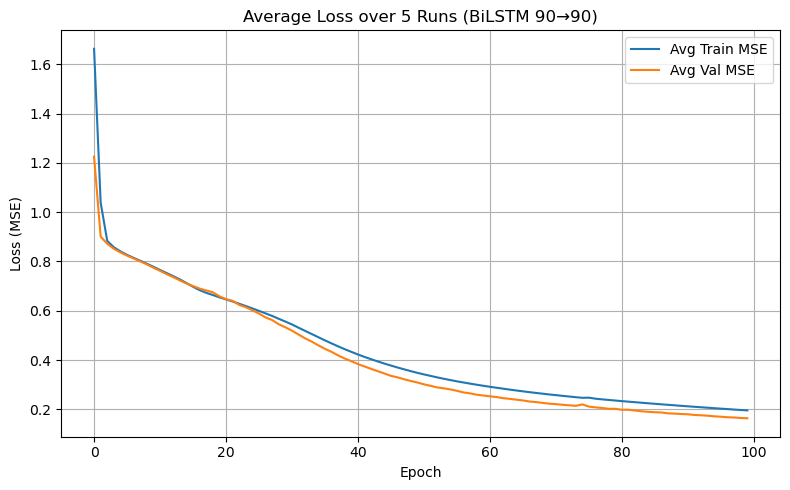

In [6]:
max_len = max(len(x) for x in all_train_losses)

def pad(arr):
    return np.array([x + [x[-1]] * (max_len - len(x)) for x in arr])

avg_train = pad(all_train_losses).mean(axis=0)
avg_val   = pad(all_val_losses).mean(axis=0)

plt.figure(figsize=(8, 5))
plt.plot(avg_train, label="Avg Train MSE")
plt.plot(avg_val, label="Avg Val MSE")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Average Loss over 5 Runs (BiLSTM 90→90)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("output/pics/loss/pred90/avg_loss_over_5_runs.png", dpi=300)
plt.show()

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch

os.makedirs("output/pics/comparison/pred90", exist_ok=True)
device = "cuda:3"
# Ground truth reshape for day-level对比
gts_hour = y_test  # shape: (N, 2160)
gts_day = gts_hour.reshape(-1, 90, 24).mean(axis=2)  # shape: (N, 90)

# 缓存所有模型预测
all_model_preds_day = []

for run in range(1, 6):
    print(f"\n=== Run {run} Evaluation ===")

    # 加载模型
    model = BiLSTM_FullOutput(
        input_size=7,
        hidden_size=128,
        output_len=2160,
        num_layers=2,
        dropout=0.3
    ).to(device)
    model.load_state_dict(torch.load(f"output/models/pred90/run_{run}.pth"))
    model.eval()

    # 推理
    test_ds = torch.utils.data.TensorDataset(
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(y_test, dtype=torch.float32)
    )
    test_loader = torch.utils.data.DataLoader(test_ds, batch_size=256, shuffle=False)

    preds = []
    with torch.no_grad():
        for xb, _ in test_loader:
            xb = xb.to(device)
            pred = model(xb).cpu().numpy()
            preds.append(pred)
    preds = np.concatenate(preds, axis=0)  # shape: (N_test, 2160)
    preds_day = preds.reshape(-1, 90, 24).mean(axis=2)  # shape: (N_test, 90)

    all_model_preds_day.append(preds_day)  # 保留每组 day 级预测

    # ==== 多样本评估 ====
    sample_ids = [5 * (run - 1) + i for i in range(5)]  # 每组画 5 个样本
    mae_list = []
    mse_list = []

    for idx in sample_ids:
        gt = gts_day[idx]
        pred = preds_day[idx]
        mae = mean_absolute_error(gt, pred)
        mse = mean_squared_error(gt, pred)
        mae_list.append(mae)
        mse_list.append(mse)

        # 图保存
        plt.figure(figsize=(10, 4.5))
        plt.plot(gt, label="Ground Truth", linewidth=2)
        plt.plot(pred, label="Prediction", linewidth=2)
        plt.xlabel("Day")
        plt.ylabel("Avg Power (kW)")
        plt.title(f"Run {run} - Sample {idx} | MAE: {mae:.4f}, MSE: {mse:.4f}")
        plt.xticks(np.arange(0, 91, 5), labels=[str(i+1) for i in range(0, 91, 5)])
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"output/pics/comparison/pred90/run_{run}_sample_{idx}.png", dpi=300)
        plt.close()

    # 打印指标
    print(f"[Run {run}] MAE (day): mean = {np.mean(mae_list):.4f}, std = {np.std(mae_list):.4f}")
    print(f"[Run {run}] MSE (day): mean = {np.mean(mse_list):.4f}, std = {np.std(mse_list):.4f}")

# ==== 平均预测绘图 ====
print("\n=== Averaged Prediction over 5 Models ===")
for i in range(5):  # 样本编号：0~4
    idx = i * 5
    gt = gts_day[idx]

    preds_across_models = [preds_day[idx] for preds_day in all_model_preds_day]
    avg_pred = np.mean(preds_across_models, axis=0)

    mae = mean_absolute_error(gt, avg_pred)
    mse = mean_squared_error(gt, avg_pred)

    plt.figure(figsize=(10, 4.5))
    plt.plot(gt, label="Ground Truth")
    plt.plot(avg_pred, label="LSTM Prediction")
    plt.xlabel("Days into the Future")
    plt.ylabel("Daily Global Active Power (Sum)")
    plt.title(f"LSTM: 90-Day Power Consumption Prediction")
    plt.xticks(np.arange(0, 91, 5), labels=[str(i+1) for i in range(0, 91, 5)])
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"output/pics/comparison/pred90/avg_sample_{idx}.png", dpi=300)
    plt.close()



=== Run 1 Evaluation ===


/tmp/ipykernel_853356/3779229087.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"output/models/pred90/run_{run}.pth"))


[Run 1] MAE (day): mean = 0.0772, std = 0.0003
[Run 1] MSE (day): mean = 0.0105, std = 0.0002

=== Run 2 Evaluation ===


/tmp/ipykernel_853356/3779229087.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"output/models/pred90/run_{run}.pth"))


[Run 2] MAE (day): mean = 0.0580, std = 0.0027
[Run 2] MSE (day): mean = 0.0066, std = 0.0008

=== Run 3 Evaluation ===


/tmp/ipykernel_853356/3779229087.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"output/models/pred90/run_{run}.pth"))


[Run 3] MAE (day): mean = 0.0877, std = 0.0050
[Run 3] MSE (day): mean = 0.0165, std = 0.0013

=== Run 4 Evaluation ===


/tmp/ipykernel_853356/3779229087.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"output/models/pred90/run_{run}.pth"))


[Run 4] MAE (day): mean = 0.0879, std = 0.0032
[Run 4] MSE (day): mean = 0.0121, std = 0.0005

=== Run 5 Evaluation ===


/tmp/ipykernel_853356/3779229087.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"output/models/pred90/run_{run}.pth"))


[Run 5] MAE (day): mean = 0.0701, std = 0.0010
[Run 5] MSE (day): mean = 0.0096, std = 0.0007

=== Averaged Prediction over 5 Models ===
